### Case Study for Internship at VIE.

This notebook walks through a brief exploraorty data analysis (EDA) of the dark fleet.  Data is primarily from TankerTrackers.com while
vessel build year and deadweight ton was scraped from the internet. Web scraping was done ouside of this notebook, though code to do so
can be found within this repository (https://github.com/mjm286/vie_project/blob/main/webscrape_imo_data.py).  A summary of this work can be found at the bottom of this notebbok. Any questions 
or comments can be directed to mjm7919@gmail.com. Please visit https://github.com/mjm286/vie_project for data and code.

#### created by Matthew McCarroll
##### 08/29/2025

In [1]:
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px
import time
import glob
import numpy as np
import requests
import pandas as pd
import json
import ast
import re

#### TankerTrackers (TT), have made available free dark fleet data, via an api call or a csv download.  Below, I use the api call to get the data and unpack the columns describing what entity is applying sanctions.

In [2]:
api_url = "https://tankertrackers.com/api/sanctioned/v1"
response = requests.get(api_url)
j = response.json()

sanction_data = pd.DataFrame.from_dict(j["data"])
country_sanctions = sanction_data["sanctions"].apply(pd.Series)
sanction_fleet = pd.concat([sanction_data.drop("sanctions", axis=1), country_sanctions], axis=1)

sanction_fleet.head()

,name,imo,OFAC,UANI,ASO,EU,FCDO,GAC,UN
0,ABHRA,9282041,2025-07-30,NaN,NaN,NaN,NaN,NaN,NaN
1,ABROS,9247388,2025-05-08,2024-10-31,NaN,NaN,NaN,NaN,NaN
2,ACHILLES,9368223,NaN,NaN,2025-06-19,2025-07-20,2025-02-24,2025-06-13,NaN
3,ADELINE G,9234666,2025-08-21,2022-11-01,NaN,NaN,NaN,NaN,NaN
4,ADHARA,9353125,NaN,NaN,NaN,2025-05-21,2025-05-09,2025-06-13,NaN


#### The TT api does not provide the class size of the vessel yet they publish that data on their website https://tankertrackers.com/report/sanctioned.  I copied their table into csv and read it in.

In [3]:
vessels = pd.read_excel('dark_fleet_class_size.xlsx')
vessels.head()

,name,class_size,flag
0,A JEWEL (9244867),VLCC/ULCC,Cook Islands
1,A R G (9689031),Handysize/Handymax,Barbados
2,A S (7303803),Handysize/Handymax,North Korea
3,ABHRA (9282041),Aframax,Panama
4,ABROS (9247388),Handysize/Handymax,Curaçao


#### TT buries the imo into the name column. Let's extract those numbers and put them into its own column.

In [4]:
pattern = r'\((\d+\.?\d*)\)'

# Find all matches of the pattern in the text

vessels['imo'] = [re.findall(pattern, text) for text in vessels.name] 
vessels['imo'] = [int(x[0]) for x in vessels.imo.values] # extract values and turn them into intergers
vessels = vessels.sort_values(by='imo').reset_index(drop=True)
vessels.head()

,name,class_size,flag,imo
0,A S (7303803),Handysize/Handymax,North Korea,7303803
1,SAM JONG 2 (7408873),Handysize/Handymax,North Korea,7408873
2,SAMMA2 (8106496),Handysize/Handymax,North Korea,8106496
3,NAMSAN8 (8122347),Handysize/Handymax,North Korea,8122347
4,SHANG YUAN BAO (8126070),Handysize/Handymax,Saint Vincent and the Grenadines,8126070


In [5]:
# type of class sizes
vessels.class_size.unique()

array(['Handysize/Handymax', 'Panamax', 'Suezmax', 'Aframax', 'VLCC/ULCC'],
      dtype=object)

#### The entities applying the sanctions are not applied to every single vessel.  
#### It is important to understand how many sancions each vessel has to her(?) name.

In [6]:
sanction_fleet = sanction_fleet.sort_values(by='imo').reset_index(drop=True)

def count_sanctions(data):
    sanction_fleet[f"{data}_numeric"] = np.where(sanction_fleet[f"{data}"].notna(), 1, 0)
    return sanction_fleet

categorical_bans=list(sanction_fleet.columns[2:9:])
[count_sanctions(d) for d in categorical_bans]
sanction_fleet['total_sanctions'] = sanction_fleet[sanction_fleet.columns[-7:]].sum(axis=1)
sanction_fleet.head()

,name,imo,OFAC,UANI,ASO,EU,FCDO,GAC,UN,OFAC_numeric,UANI_numeric,ASO_numeric,EU_numeric,FCDO_numeric,GAC_numeric,UN_numeric,total_sanctions
0,A S,7303803,2025-06-10,NaN,NaN,NaN,2018-03-30,NaN,2018-03-30,1,0,0,0,1,0,1,3
1,SAMJONG2,7408873,2025-06-08,NaN,NaN,NaN,2018-03-30,NaN,2018-03-30,1,0,0,0,1,0,1,3
2,SAMMA2,8106496,2025-06-09,NaN,NaN,NaN,2018-03-30,NaN,2018-03-30,1,0,0,0,1,0,1,3
3,NAMSAN8,8122347,2025-05-08,NaN,NaN,NaN,2018-03-30,NaN,2018-03-30,1,0,0,0,1,0,1,3
4,SHANG YUAN BAO,8126070,2025-05-08,NaN,NaN,NaN,2018-03-30,NaN,2018-10-16,1,0,0,0,1,0,1,3


#### merge the api data with vessel size and tidy up column names

In [7]:
df_sanction_fleet = pd.merge(vessels, sanction_fleet, how='left', on='imo', suffixes=('_TT_csv','_TT_api'))
df_sanction_fleet = df_sanction_fleet.drop('name_TT_csv', axis=1)
df_sanction_fleet = df_sanction_fleet.rename(columns={'name_TT_api':'name'})

#### read in the scraped data and merge with TT data

In [8]:
scraped_data = pd.read_csv('final_dwt_data.csv') # compiled offline. data uploaded to github vie_project repo

df_sanction_fleet = pd.merge(df_sanction_fleet, scraped_data, how='left', on='imo', suffixes=('_TT','_scraped'))
df_sanction_fleet[df_sanction_fleet.DWT.isna()] # at time of coding I was abe to web scrape all but 1 vessel
df_sanction_fleet = df_sanction_fleet[~df_sanction_fleet.DWT.isna()]
df_sanction_fleet = df_sanction_fleet.drop('name_scraped', axis=1).reset_index(drop=True)
df_sanction_fleet = df_sanction_fleet.rename(columns={'name_TT':'name'})

df_sanction_fleet.shape[0]

1210

In [9]:
df_sanction_fleet.head()

,class_size,flag,imo,name,OFAC,UANI,ASO,EU,FCDO,GAC,...,ASO_numeric,EU_numeric,FCDO_numeric,GAC_numeric,UN_numeric,total_sanctions,ship_type,build_year,gross_tonnage,DWT
0,Handysize/Handymax,North Korea,7303803,A S,2025-06-10,NaN,NaN,NaN,2018-03-30,NaN,...,0,0,1,0,1,3,Chemical Tanker,1973.0,1757.0,3003.0
1,Handysize/Handymax,North Korea,7408873,SAMJONG2,2025-06-08,NaN,NaN,NaN,2018-03-30,NaN,...,0,0,1,0,1,3,Chemical/Oil Products Tanker,1975.0,1676.0,2507.0
2,Handysize/Handymax,North Korea,8106496,SAMMA2,2025-06-09,NaN,NaN,NaN,2018-03-30,NaN,...,0,0,1,0,1,3,Oil Products Tanker,1981.0,962.0,1731.0
3,Handysize/Handymax,North Korea,8122347,NAMSAN8,2025-05-08,NaN,NaN,NaN,2018-03-30,NaN,...,0,0,1,0,1,3,Crude Oil Tanker,1982.0,1914.0,3150.0
4,Handysize/Handymax,Saint Vincent and the Grenadines,8126070,SHANG YUAN BAO,2025-05-08,NaN,NaN,NaN,2018-03-30,NaN,...,0,0,1,0,1,3,Oil Products Tanker,1982.0,3508.0,6031.0


In [10]:

# Shoutout to @oilBandit@x.com who gave away darkfleet data sometime around March 2023 on Twitter. I might play around with data as it has compliant vessels
oilBandit_data = pd.read_csv("Shadow_Fleet_oilBandit.csv")

columns = [str.lower(x.replace(" ","_")) for x in oilBandit_data.columns]
oilBandit_data.columns = columns
oilBandit_data["controller"] = [str(x).lower() for x in oilBandit_data["controller"]]
oilBandit_data = oilBandit_data.rename(columns={"name_of_ship":"name","year_of_build":"build_year"})

df =pd.merge(df_sanction_fleet, oilBandit_data, on='imo', how='left', suffixes=('_TankerTrackers', '_oilBandit'))
df = df.rename(columns={'build_year_TankerTrackers':'build_year', 'gross_tonnage_TankerTrackers':'gross_tonnage'})
df['age'] = 2026 - df.build_year

In [11]:
df.total_sanctions.max()

6

#### start visualizing data

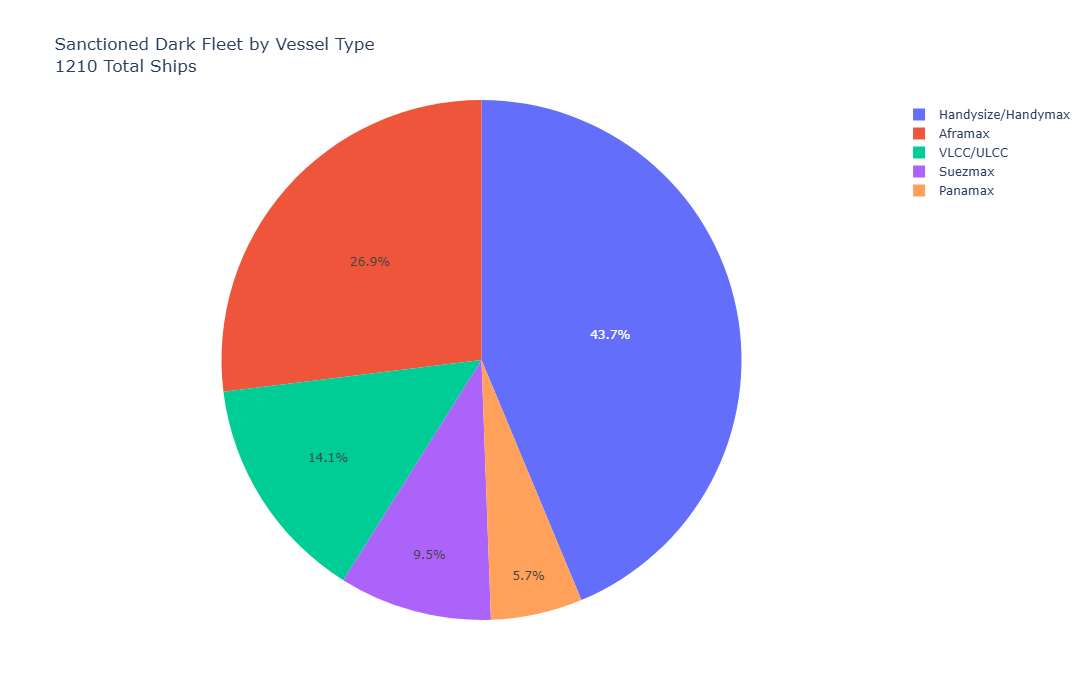

In [12]:
pie_chart = df.groupby(['class_size']).count()

pie_chart = pie_chart.reset_index()
pie_chart = pie_chart.rename(columns={'name_TankerTrackers':'total_vessels'})

fig = px.pie(pie_chart, values='total_vessels', names='class_size', title=f"Sanctioned Dark Fleet by Vessel Type <br>{df.shape[0]} Total Ships")
fig.update_layout(width=700, height=700)
fig.show()
fig.write_html("piechart_interactive_plot.html")


#### We see an almost 50/50 split between sanctioned crude oil tankers and handymax/panamax vessels.
Lets focus on the larger oil tankers

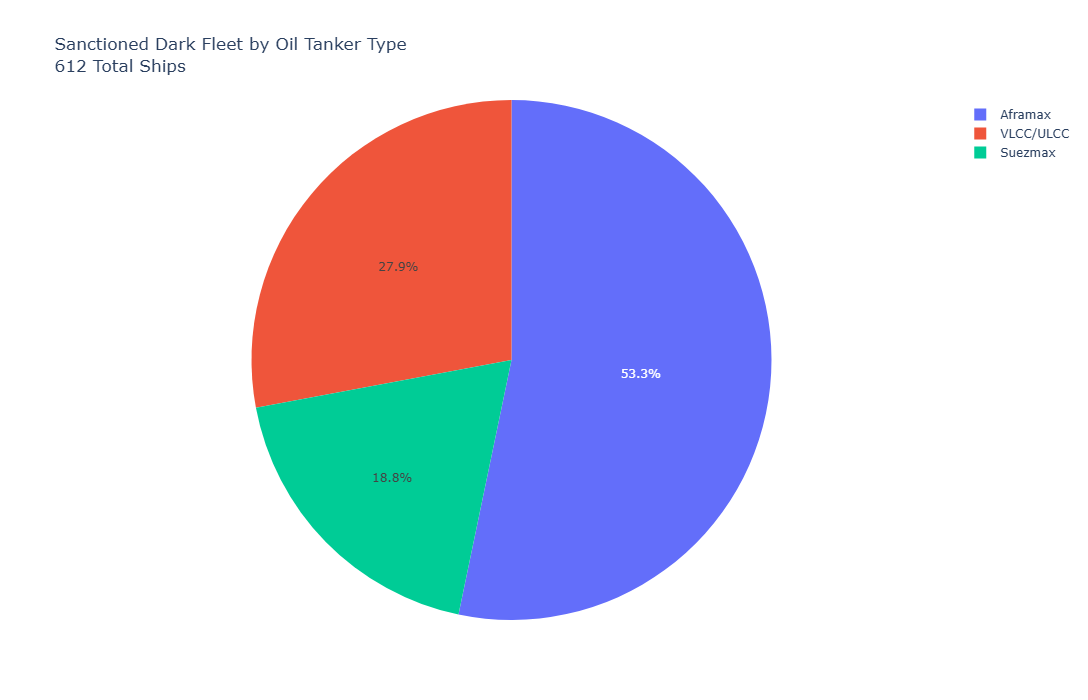

In [13]:
oil_ships = df.query('class_size=="Suezmax" or class_size=="VLCC/ULCC" or class_size=="Aframax"')
f"ships that transport oil: {oil_ships.shape[0]}"

pie_chart = oil_ships.groupby(['class_size']).count()

pie_chart = pie_chart.reset_index()
pie_chart = pie_chart.rename(columns={'name_TankerTrackers':'total_vessels'})
fig = px.pie(pie_chart, values='total_vessels', names='class_size', title=f"Sanctioned Dark Fleet by Oil Tanker Type <br>{oil_ships.shape[0]} Total Ships")
fig.update_layout(width=700, height=700)
fig.show()
fig.write_html("oil_piechart_interactive_plot.html")

#### Half are aframaxes with almst a third VLCCs.

#### Looking at DWT

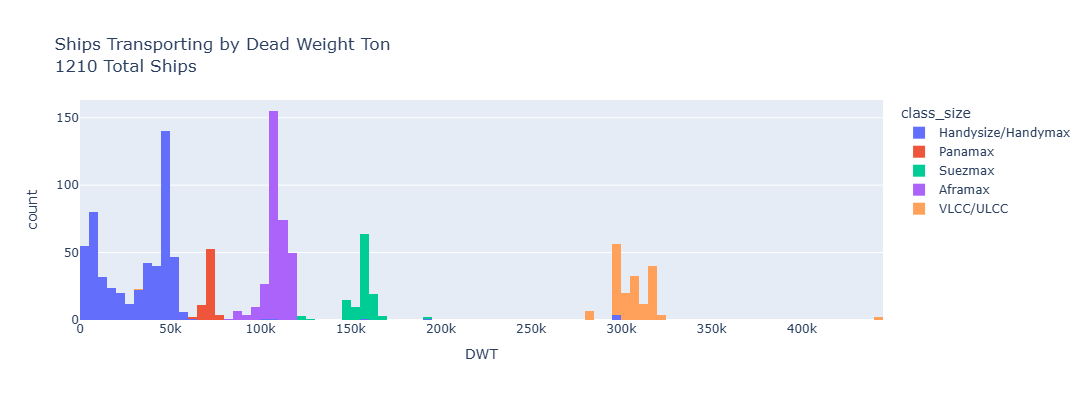

In [14]:
fig = px.histogram(df, x="DWT", color="class_size", nbins=100, title=f"Ships Transporting by Dead Weight Ton <br>"
                                                                            f"{df.shape[0]} Total Ships")
fig.update_layout(width=1000, height=400)
fig.show()
fig.write_html("all_ships_dwt_interactive_plot.html")


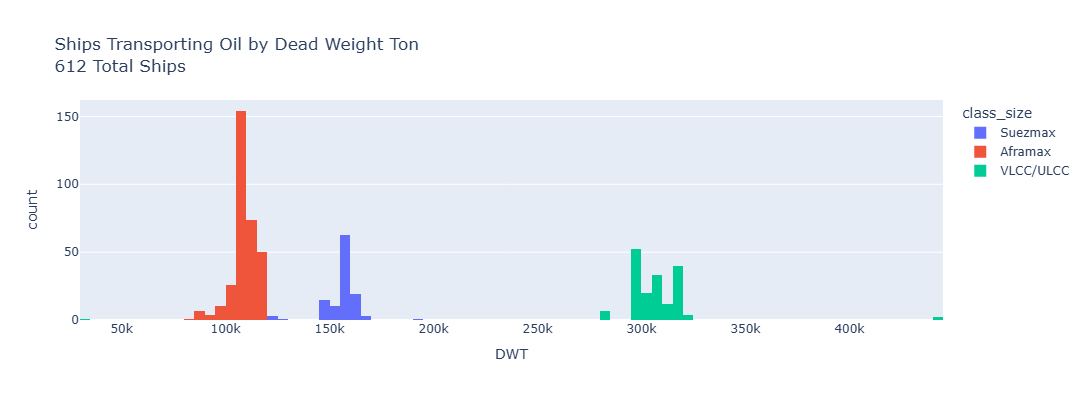

In [15]:
fig = px.histogram(oil_ships, x="DWT", color="class_size", nbins=100, title=f"Ships Transporting Oil by Dead Weight Ton <br>"
                                                                            f"{oil_ships.shape[0]} Total Ships")
fig.update_layout(width=1000, height=400)
fig.show()
fig.write_html("oil_ships_dwt_interactive_plot.html")


#### The class sizes neatly separates themselves

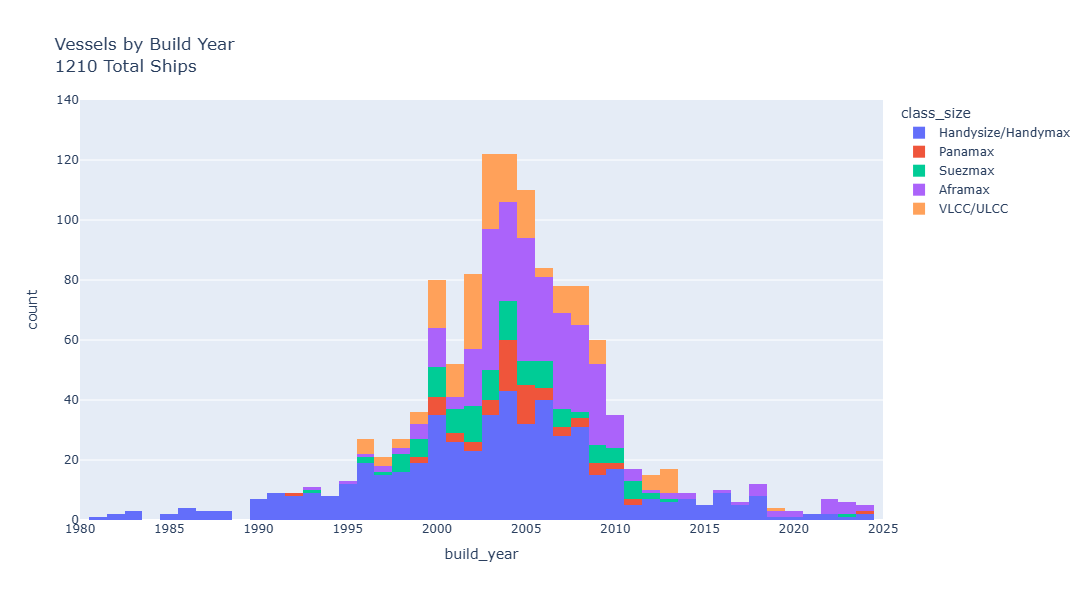

In [16]:
fig = px.histogram(df, x="build_year", color="class_size", nbins=100, title=f"Vessels by Build Year <br>"
                                                                            f"{df.shape[0]} Total Ships")
fig.update_layout(width=900, height=600)
fig.update_layout(
    xaxis=dict(range=[1980, 2025]),  # Sets x-axis range
    yaxis=dict(range=[0, 140])  # Sets y-axis range
)

fig.show()
fig.write_html("all_ships_year_interactive_plot.html")


#### Sanctioned vessels average 20ish years in age

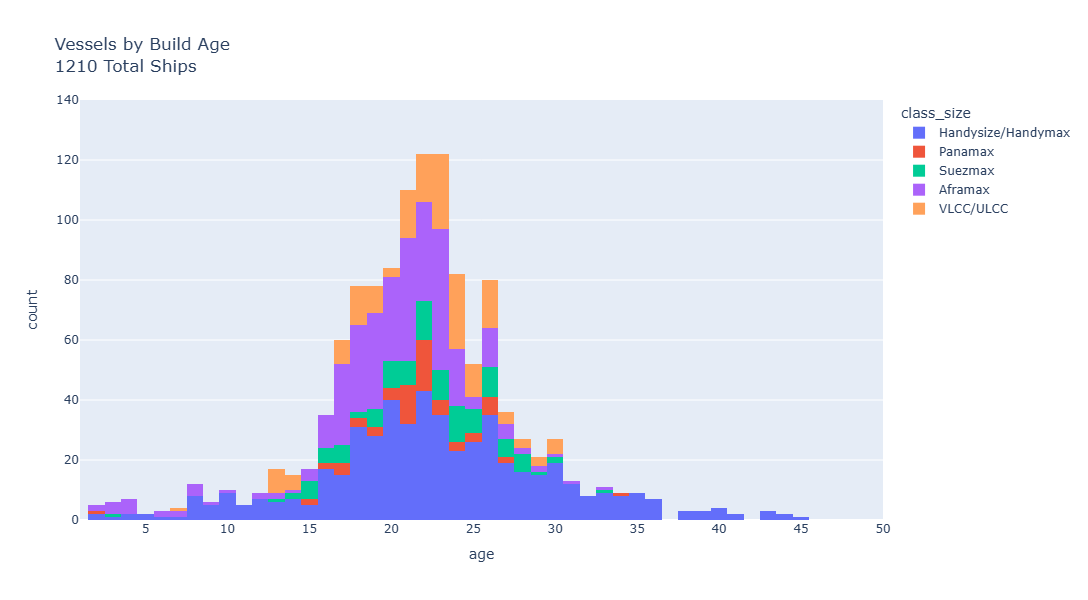

In [17]:
fig = px.histogram(df, x="age", color="class_size", nbins=100, title=f"Vessels by Build Age <br>"
                                                                            f"{df.shape[0]} Total Ships")
fig.update_layout(width=900, height=600)
fig.update_layout(
    xaxis=dict(range=[1, 50]),  # Sets x-axis range
    yaxis=dict(range=[0, 140])  # Sets y-axis range
)

fig.show()
fig.write_html("all_ships_age_interactive_plot.html")


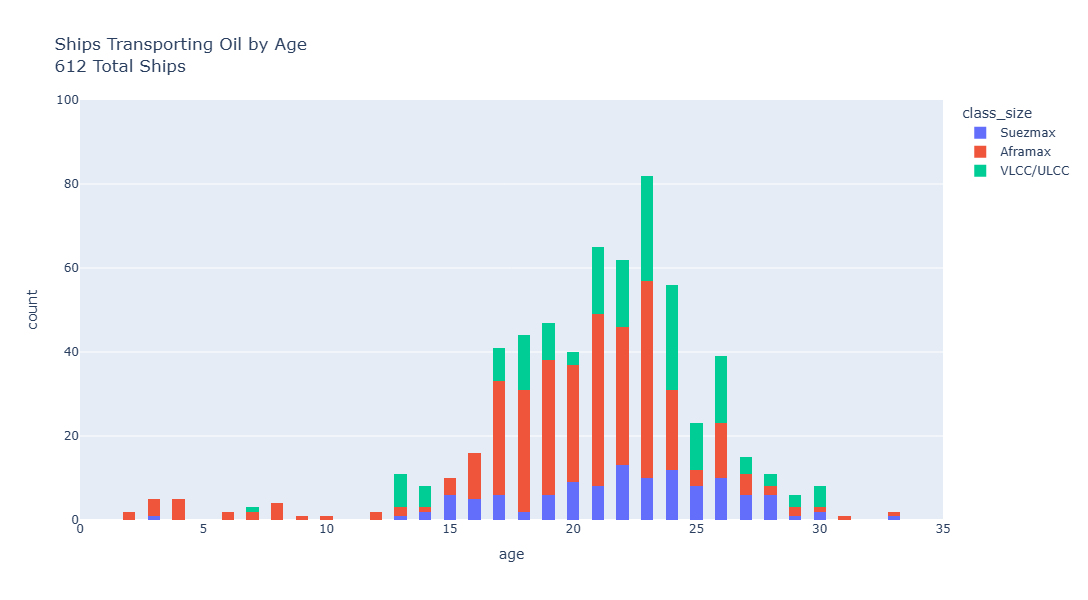

In [18]:
fig = px.histogram(oil_ships, x="age", color="class_size", nbins=100, title=f"Ships Transporting Oil by Age<br>"
                                                                            f"{oil_ships.shape[0]} Total Ships")
fig.update_layout(width=900, height=600)
fig.update_layout(
    xaxis=dict(range=[0, 35]),  # Sets x-axis range
    yaxis=dict(range=[0, 100])  # Sets y-axis range
)

fig.show()
fig.write_html("oil_ships_year_interactive_plot.html")


#### VLCCs have even distribution in build year.

#### visualize vessel count by DWT for Suez, Afras ad VLCCs

categories: ['0 to 25,000 DWT', '25,000 to 50,000 DWT', '50,000 to 100,000 DWT', '100,000 to 150,000 DWT', '150,000 to 275,000 DWT', '275,000 + DWT']


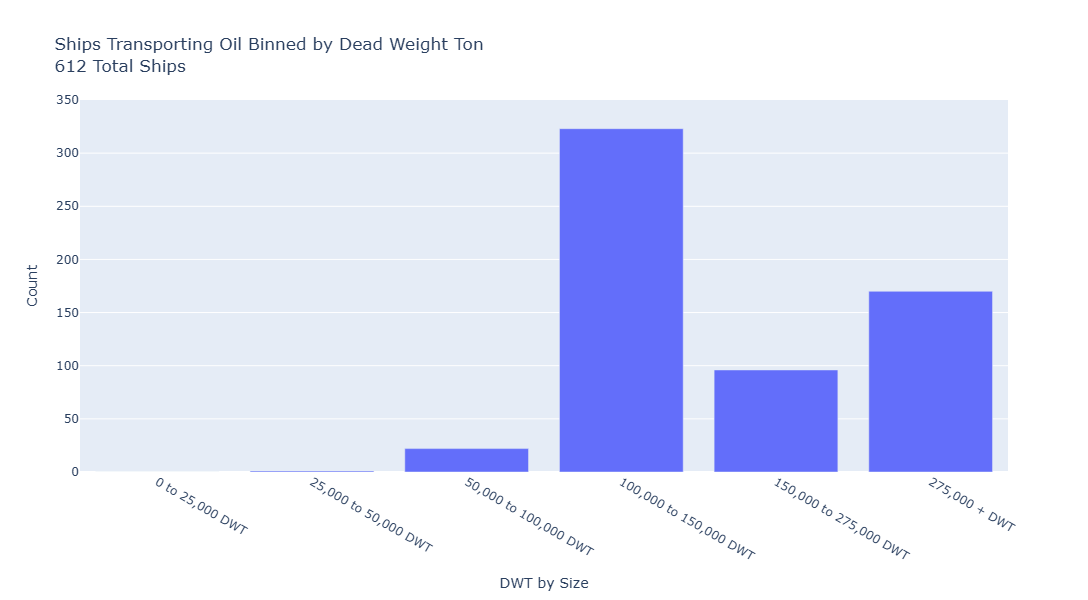

In [19]:
custom_bins = np.array([0, 25, 50, 100, 150, 275, np.inf])*1000
binned_data_custom = pd.cut(oil_ships.DWT, bins=custom_bins, include_lowest=False, right=True)
# You can then count the occurrences in each bin
bin_counts = binned_data_custom.value_counts().sort_index()

# make categorical values for binned plot 
cats = []
for idx, x in enumerate(binned_data_custom.cat.categories):
    left = f"{x.left:.0f}"
    right = f"{x.right:.0f}"
    if right=="inf":
        cats.append((f"{int(left):,} + DWT"))
    else:
        cats.append((f"{int(left):,} to {int(right):,} DWT"))
print(f"categories: {cats}")

fig = px.bar(x=cats, y=bin_counts.values, title=f"Ships Transporting Oil Binned by Dead Weight Ton <br>"
                                                                            f"{oil_ships.shape[0]} Total Ships")
fig.update_layout(width=800, height=600)
fig.update_layout(
    xaxis_title="DWT by Size",  # Set the x-axis title
    yaxis_title="Count"  # Set the y-axis title
)
fig.update_layout(
    yaxis=dict(range=[0, 350])  # Sets y-axis range from 0 to 20
)

fig.show()
fig.write_html("oil_ships_dwt_binned_interactive_plot.html")


In [20]:
minvlcc = df.query('class_size=="VLCC/ULCC"').DWT.min()
maxvlcc = df.query('class_size=="VLCC/ULCC"').DWT.max()
print(f"smallest VLCC is {minvlcc} DWT")
print(f"largest VLCC is {maxvlcc} DWT")

smallest VLCC is 30061.0 DWT
largest VLCC is 441585.0 DWT


In [21]:
df.query('DWT==@maxvlcc').iloc[0]

class_size                     VLCC/ULCC
flag_TankerTrackers              Bahamas
imo                              9246633
name_TankerTrackers           SA OCEANIA
OFAC                                 NaN
UANI                          2023-03-31
ASO                                  NaN
EU                                   NaN
FCDO                                 NaN
GAC                                  NaN
UN                                   NaN
OFAC_numeric                           0
UANI_numeric                           1
ASO_numeric                            0
EU_numeric                             0
FCDO_numeric                           0
GAC_numeric                            0
UN_numeric                             0
total_sanctions                        1
ship_type                            FSO
build_year                        2003.0
gross_tonnage                   234006.0
DWT                             441585.0
name_oilBandit                   OCEANIA
gross_tonnage_oi

#### A quick look at what sanctions are doing

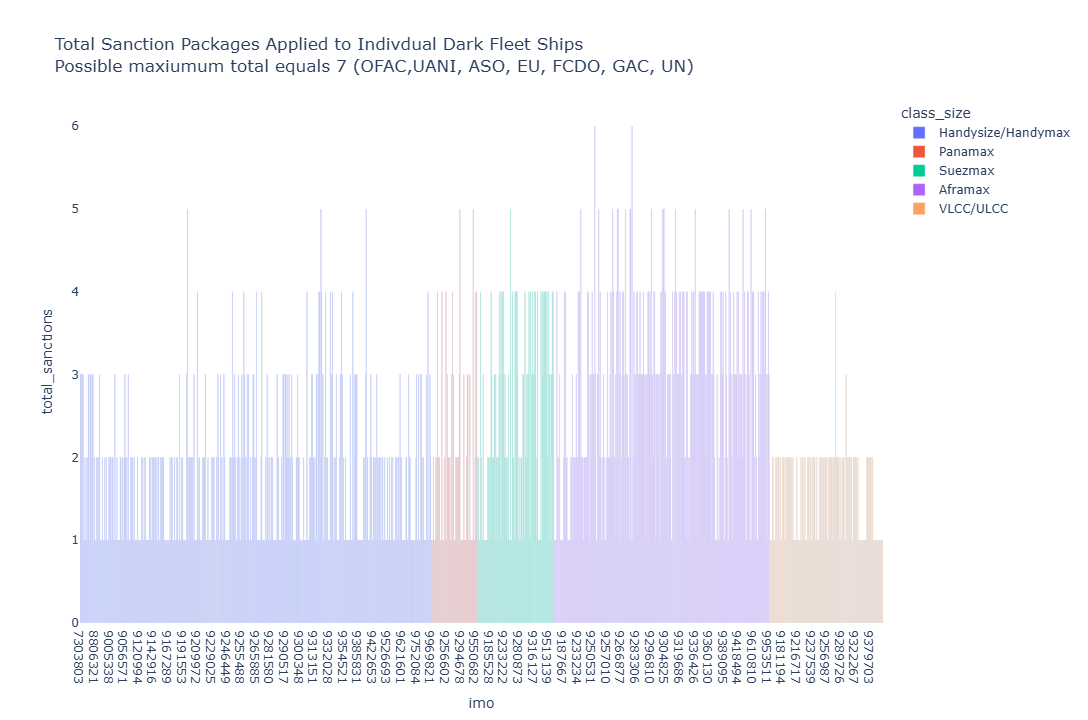

In [22]:
df['imo'] = df.imo.astype(str)
df = df.sort_values(by='imo').reset_index(drop=True)

fig = px.bar(df, x='imo', y='total_sanctions', color="class_size", title='Total Sanction Packages Applied to Indivdual Dark Fleet Ships<br>'
                                                                      'Possible maxiumum total equals 7 (OFAC,UANI, ASO, EU, FCDO, GAC, UN)')
fig.update_layout(width=1200, height=700)
fig.update_layout(
    paper_bgcolor='white',  # Background color of the entire chart
    plot_bgcolor='white'     # Background color of the plot area
)

# Show the plot
fig.show()
# fig.write_html("total_sanctioned_bodies_interactive_plot.html")


#### Not a single vessel has all 7 sanctions applied to it!
##### A quick breakdown

In [23]:
pd.set_option('display.precision', 2) 
x=df.groupby(['class_size'])[['build_year','age','DWT','total_sanctions']].mean()
x.columns = [f"{col}_average" for col in x.columns]
x

,build_year_average,age_average,DWT_average,total_sanctions_average
class_size,,,,
Aframax,2006.16,19.84,108439.32,2.78
Handysize/Handymax,2002.94,23.06,33211.24,1.67
Panamax,2004.61,21.39,72610.10,1.86
Suezmax,2004.00,22.00,156794.89,2.43
VLCC/ULCC,2003.98,22.02,306063.88,1.55


#### Most vessesls have just one sanctions enitity applied!

In [24]:
df.to_csv('sanctioned_fleet_data.csv', index=False)

# Summary

Western nations are trying to curtial and reduce the flow of financial resources to Russia by reducing the flow of its seaborne oil and oil byproducts.  Sanctions have been applied to suspected/verified vessels assisting in Russian oil transport.  It is unfortunate that sanctions are not applied more broadly to all vessels.  For example, VLCCs have minimum sanctions applied in terms of total possible.  I would think more sanctions and more coordination would be more effective in stopping Russian oil flow.

There are lots of things that can be looked at given more access to data.  Something I think worthwhile would be to track each sanctioned vessel using its AIS data from TankerTrackers.  Minimal movement could indicate the vessel is storing oil or is essentially without a home and is decommissioned.  Analysis of AIS data could shed more light on how much oil is actually flowing.  oil flows coupled with supply/demand could help explain or predict shipping costs. 